<a href="https://colab.research.google.com/github/SageSquash/Pizza-Application/blob/master/Copy_of_Untitled22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np

class Histogram:

	def sub_histogram_equalization(self, histogram, range_min = 0, range_max = 255):
		cdf = histogram.cumsum()
		cdf_mask = np.ma.masked_equal(cdf, 0)
	
		# Scale cdf to [range_min, range_max]
		scale_cdf_mask = ((cdf_mask - cdf_mask.min()) * (range_max - range_min) / (cdf_mask.max() - cdf_mask.min())) + range_min
		LUT = np.ma.filled(scale_cdf_mask, 0).astype('uint8')

		return LUT

	def histogram_equalization(self, image_1d, range_min = 0, range_max = 255):
		histogram, _ = np.histogram(image_1d, range_max - range_min + 1, [range_min, range_max])

		return self.sub_histogram_equalization(histogram, range_min, range_max)

	def histogram_equalization_threshold(self, image_1d, threshold, start = 0, end = 255):
		lower_filter = image_1d <= threshold
		lower_1d = image_1d[lower_filter]

		upper_filter = image_1d > threshold
		upper_1d = image_1d[upper_filter]

		lower_input_lut = np.array([])
		if start > 0:
			for i in range(0, start):
				lower_input_lut = np.append(lower_input_lut, i)

		upper_input_lut = np.array([])
		if end < 255:
			for i in range(end + 1, 256):
				upper_input_lut = np.append(upper_input_lut, i)

		lower_LUT = self.histogram_equalization(lower_1d, start, threshold)
		upper_LUT = self.histogram_equalization(upper_1d, threshold + 1, end)

		lower_LUT = np.concatenate((lower_input_lut, lower_LUT))
		upper_LUT = np.concatenate((upper_LUT, upper_input_lut))

		LUT = np.concatenate((lower_LUT, upper_LUT))

		return LUT

	def histogram_equalization_recursively(self, image_1d, separate_func, recursive, start = 0, end = 255):
		if recursive > 0:
			separate = separate_func(image_1d)
			separate = math.floor(separate)

			lower_filter = image_1d <= separate
			lower_1d = image_1d[lower_filter]
			
			lower_equalization = self.histogram_equalization_recursively(lower_1d, separate_func, recursive - 1, start, separate)

			upper_filter = image_1d > separate
			upper_1d = image_1d[upper_filter]

			upper_equalization = self.histogram_equalization_recursively(upper_1d, separate_func, recursive - 1, separate + 1, end)

			return np.concatenate((lower_equalization, upper_equalization))
		else:
			return self.histogram_equalization(image_1d, start, end)


In [2]:
import math
import numpy as np
import cv2 as cv

class Utils:
	def __init__(self, image, color_space = 'HSV'):
		self.image = image
		self.color_space = color_space

	def image_gray(self):
		if (self.color_space == 'HSV'):
			image_hsv = cv.cvtColor(self.image, cv.COLOR_BGR2HSV)
			self.image_color = image_hsv

			return image_hsv[:, :, 2]
		elif (self.color_space == 'Gray'):
			image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
			self.image_color = image_gray

			return image_gray
		else:
			self.image_color = self.image
			return self.image

	def LUT_image(self, LUT):
		if (self.color_space == 'HSV'):
			for i in range(0, len(self.image_color)):
				for j in range(0, len(self.image_color[0])):
					self.image_color[i][j][2] = LUT[self.image_color[i][j][2]]

			return cv.cvtColor(self.image_color, cv.COLOR_HSV2BGR)
		elif (self.color_space == 'Gray'):
			return LUT[self.image_color]
		else:
			return self.image_color

	def is_gray_image(self):
		blue, green, red = cv2.split(self.image)

		difference_red_green = np.count_nonzero(abs(red - green))
		difference_green_blue = np.count_nonzero(abs(green - blue))
		difference_blue_red = np.count_nonzero(abs(blue - red))

		difference_sum = float(difference_red_green + difference_green_blue + difference_blue_red)

		ratio = difference_sum / self.image.size

		if ratio>0.005:
				return False
		else:
				return True

	def minimum_mean_brightness_error(self, image_1d):
		length = len(image_1d)

		unique_1d = np.unique(image_1d)
		max_1d = len(unique_1d)

		histogram, _ = np.histogram(image_1d, 256, [0, 255])

		mean = 0
		for i in range(0, len(unique_1d)):
			mean += i * histogram[unique_1d[i]]

		smbe = max_1d * (length - histogram[unique_1d[0]]) - 2 * mean
		asmbe = abs(smbe)
		position = 0
		for i in range(1, len(unique_1d)):
			smbe += (length - max_1d * histogram[unique_1d[i]])
			if asmbe > abs(smbe):
				asmbe = abs(smbe)
				position = i

		return unique_1d[position]


In [3]:
class IE:
    def __init__(self, image, color_space = 'HSV'):
        self.image = image
        self.color_space = color_space

    # Kim, Yeong-Taeg.
    # Contrast enhancement using brightness preserving bi-histogram equalization. 
    # IEEE transactions on Consumer Electronics 43, no. 1 (1997): 1-8.
    # Brightness-preserving Bi-Histogram Equalization (BBHE)
    def BBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mean = np.mean(image_1d)
        mean = math.floor(mean)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mean)
        return utils.LUT_image(LUT)
    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Contrast enhancement using recursive mean-separate histogram equalization for scalable brightness preservation.
    # IEEE Transactions on consumer Electronics 49, no. 4 (2003): 1301-1309.
    # Recursive Mean-Separate Histogram Equalization (RMSHE)
    def RMSHE(self, recursive = 2):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        histogram = Histogram()
        LUT = histogram.histogram_equalization_recursively(image_1d, np.mean, recursive)
        return utils.LUT_image(LUT)
    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Minimum mean brightness error bi-histogram equalization in contrast enhancement.
    # IEEE transactions on Consumer Electronics 49, no. 4 (2003): 1310-1319.
    # Minimum Mean Brightness Error Histogram Equalization (MMBEBHE)
    def MMBEBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mbe = utils.minimum_mean_brightness_error(image_1d)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mbe)
        return utils.LUT_image(LUT)
    # Wang, Yu, Qian Chen, and Baeomin Zhang.
    # Image enhancement based on equal area dualistic sub-image histogram equalization method.
    # IEEE Transactions on Consumer Electronics 45, no. 1 (1999): 68-75.
    # Dualistic Sub-Image Histogram Equalization (DSIHE)
    def DSIHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        median = np.median(image_1d)
        median = math.floor(median)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, median)
        return utils.LUT_image(LUT)

In [21]:
import math
import numpy as np

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    err /= float(image_input.shape[0] * image_input.shape[1])
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    return 10 * math.log10(255 * 255 / MSE(image_input, image_output))


In [19]:
def MSE(image_input, image_output):
    err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    err /= float(image_input.shape[0] * image_input.shape[1])
    return (err)

In [32]:
import PIL
import cv2
from PIL import Image
import numpy as np
from IPython.display import display
from numpy import cumsum
import sys
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow
# img1 = cv2.cvtColor(io.imread('https://upload.wikimedia.org/wikipedia/commons/d/d3/PSNR-example-base.png'), cv2.COLOR_RGB2BGR)
# img2 = cv2.cvtColor(io.imread('https://upload.wikimedia.org/wikipedia/commons/2/2a/PSNR-example-comp-90.jpg'), cv2.COLOR_RGB2BGR)
img3 = cv2.imread('/content/Y13.jpg',cv2.IMREAD_COLOR)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

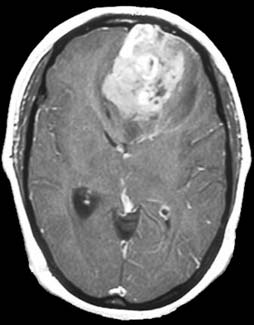

In [33]:
# Original Image
cv2_imshow(img3)

In [ ]:
# # Applying BBHE
# check = IE(img3,color_space = 'HSV')
# cv2_imshow(check.BBHE())

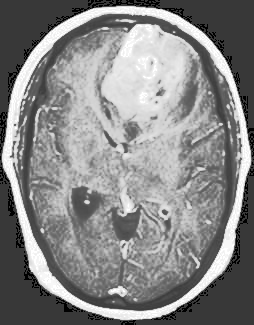

386.94284918231375
22.254335356878222
28.229606299212605


In [34]:
check = IE(img3)
img_output = check.BBHE()
cv2_imshow(check.BBHE())
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))

In [ ]:
# # Applying RMSHE
# check = IE(img1,color_space = 'HSV')
# cv2_imshow(check.RMSHE())

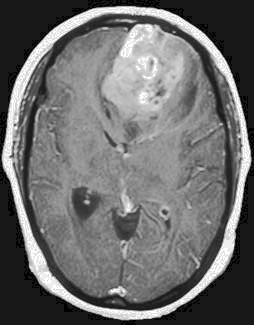

59.4125269533616
30.39202336541009
2.8467474258025476


In [35]:
check = IE(img3)
img_output = check.RMSHE()
cv2_imshow(check.RMSHE())
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))

In [ ]:
# # Applying MMBEBHE
# check = IE(img1,color_space = 'HSV')
# cv2_imshow(check.MMBEBHE())

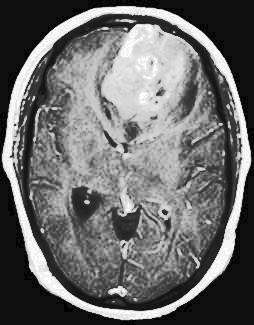

146.9045051483949
26.460452462819653
1.8035251362810527


In [36]:
check = IE(img3)
img_output = check.MMBEBHE()
cv2_imshow(check.MMBEBHE())
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))

In [ ]:
# # Applying DSIHE
# check = IE(img1,color_space = 'HSV')
# cv2_imshow(check.DSIHE())

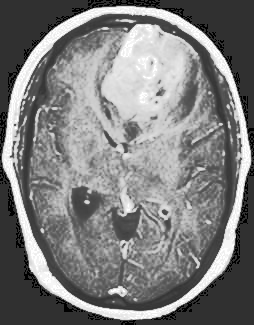

262.0851932162326
23.94637875160267
19.237758933979407


In [37]:
check = IE(img3)
img_output = check.DSIHE()
cv2_imshow(check.DSIHE())
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))